In [1]:
# CMSC426 Project 3
# GROUP MEMBERS: Andrew Sumner (asumner1), Teimuraz Trapaidze (ttrapaid)
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches
import cv2
from scipy import ndimage
import math
import random
import sklearn as sk
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# CONVERT IMAGES TO GRAYSCALE?????

In [2]:
folders = ["images/dolphin", "images/airplanes", "images/Leopards"]

def get_imgs_from_folders(folders):
    image_sets = []
    for folder in folders:
        images = []
        i = 0
        for filename in os.listdir(folder):
            i = i + 1
            image = img.imread(os.path.join(folder,filename))
            images.append(image)
            if i >= 65:
                break
        image_sets.append(images)
    return image_sets

all_images = get_imgs_from_folders(folders)

In [3]:
desc_all_imgs = []
kp_all_imgs = []
all_imgs_full_data = []
min_num_kp = 999999999999999

# FIRST LOOP FINDS MIN KP BOUND
for img_set in all_images:
    for image in img_set:
        sift = cv2.SIFT_create()
        kp, descriptors = sift.detectAndCompute(image, None)
        if len(kp) < min_num_kp:
            min_num_kp = len(kp)

print("MIN NUM KP =", min_num_kp)



# SECOND LOOP FINDS BEST KEYPOINTS WHERE ALL IMGS HAVE SAME (MIN) NUM
i = -1
for img_set in all_images:
    i += 1
    img_set_full_data = []
    for image in img_set:
        sift = cv2.SIFT_create(nfeatures=min_num_kp)
        kp, descriptors = sift.detectAndCompute(image, None)
        kp = kp[:min_num_kp]
        descriptors = descriptors[:min_num_kp]
        img_set_full_data.append((image, i, kp, descriptors))
        desc_all_imgs.append(descriptors)
        kp_all_imgs = kp_all_imgs + kp
    all_imgs_full_data.append(img_set_full_data)
#     print(descriptors.shape)
#     for pt, desc in zip(kp, descriptors):
#         (x,y) = pt.pt
#         print((x,y), desc)

desc_all_imgs = tuple(desc_all_imgs)
desc_all_imgs = np.vstack(desc_all_imgs)
#print(desc_all_imgs)
print()
print(desc_all_imgs.shape)

MIN NUM KP = 34

(6630, 128)


In [4]:
# splitting train and test
# note that we already know the labels since the folders are still
# separated within the output data structure (for now)
train_x = []
test_x = []
train_y = []
test_y = []

i = -1

for img_set in all_imgs_full_data:
    i += 1
    train_x_subset, test_x_subset = train_test_split(img_set, test_size=0.1)
    train_x = train_x + train_x_subset
    test_x = test_x + test_x_subset
    train_y = train_y + (np.full(len(train_x_subset), i)).tolist()
    test_y = test_y + (np.full(len(test_x_subset), i)).tolist()
    
print(test_y)

desc_all_train_imgs = [d for (_,_,_,d) in train_x]
desc_all_train_imgs = tuple(desc_all_train_imgs)
desc_all_train_imgs = np.vstack(desc_all_train_imgs)
print(len(desc_all_train_imgs))

[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
5916


In [5]:
def clustering(keypoints, descriptors, k):
    num_descs = descriptors.shape[0]
    
    center_descs = []
    # initial random k centers
    for i in range(k):
        center = random.randint(0, num_descs-1)
        center_descs.append(descriptors[center])
        
    check = False
    
    while (not check):
        clusters = {i:[] for i in range(k)}
            
        for descriptor in descriptors:
            closest = 99999999999
            i = 0
            for center_desc in center_descs:
                dist = np.sum((center_desc-descriptor)**2)

#                 dist = np.linalg.norm(center_desc - descriptor)
                if dist < closest:
                    closest = dist
                    closest_center = i
                i += 1

            clusters[closest_center].append(descriptor)
            
        old_centers = center_descs
        center_descs = []
        
        for center_num, cluster in clusters.items():
            if (len(cluster) > 0):
                cluster = np.vstack(cluster)
#                 new_center = np.sum(cluster, axis=0)/np.linalg.norm(cluster)
                new_center = cluster.mean(axis=0)
                center_descs.append(new_center)
        
        check = True
        for old, new in zip(old_centers, center_descs):
            if not np.array_equal(old, new):
                check = False
                break
        
        

    return center_descs

In [6]:
def clustering2(descriptors, k):
    indices = range(0, len(descriptors))
    centroid_indices = random.sample(indices, k)
    
    centroids = []
    for i in centroid_indices:
        centroids.append(descriptors[i])
    old_centroids = []
    
    flag = False
    
    while (not flag):
        centroid_groupings = {centroid_idx:[] for centroid_idx in range(len(centroids))}
        for row in descriptors:
            min_dist = 9999999999999999
            min_centroid = None
            min_centroid_idx = -1
            i = -1
            for centroid in centroids:
                i = i+1
                dist = np.linalg.norm(row - centroid)
                if dist < min_dist:
                    min_dist = dist
                    min_centroid = centroid
                    min_centroid_idx = i
            (centroid_groupings[min_centroid_idx]).append(row)
        
        old_centroids = centroids.copy()
        for i in range(len(centroids)):
            cluster_descs = centroid_groupings[i]
            #print(len(cluster_descs))
            cluster_descs = tuple(cluster_descs)
            cluster_descs = np.vstack(cluster_descs)
            new_centroid = cluster_descs.mean(axis=0)
            #print(new_centroid)
            #print(new_centroid.shape)
            centroids[i] = new_centroid
            #print(centroids)
        #print(centroids)
        #print(old_centroids)
        flag = np.array_equal(
            np.vstack(tuple(centroids)), 
            np.vstack(tuple(old_centroids))
        )
#         print(flag)
#         print(len(centroids))
    return centroids

In [7]:
# centers = clustering(kp_all_imgs, desc_all_train_imgs, 400)
centers = clustering2(desc_all_train_imgs, 100)

In [8]:
def find_image(descriptor, training_set):
    for tup in training_set:
        for kp, desc in zip(tup[2], tup[3]):
            if np.array_equal(descriptor, desc):
                return tup[0], kp, desc
            

In [9]:
def find_closest_descriptor(centroid, descriptors):
    closest_desc = None
    min_dist = 9999999999999999
    
    for desc in descriptors:
        dist = np.linalg.norm(desc - centroid)
        if dist < min_dist:
            min_dist = dist
            closest_desc = desc

    return closest_desc


Patch around centroid outlined in red


<Figure size 576x576 with 0 Axes>

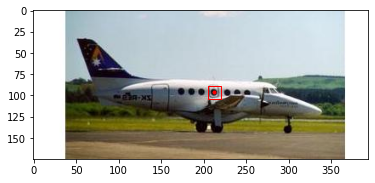

In [18]:
# pick a centroid and plot it

k = 10

centroid = centers[random.randint(0, k)]

closest_to_centroid = find_closest_descriptor(centroid, desc_all_train_imgs)
image_closest, kp_closest, desc_closest = find_image(closest_to_centroid, train_x)

plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
ax.imshow(image_closest)
ax.plot(kp_closest.pt[0], kp_closest.pt[1], '.', color='r')
rect = patches.Rectangle((kp_closest.pt[0]-7.5, kp_closest.pt[1]-7.5), 15,15, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print("Patch around centroid outlined in red")
centroid = centroid.reshape(16,8)


Patch around centroid outlined in red


<Figure size 576x576 with 0 Axes>

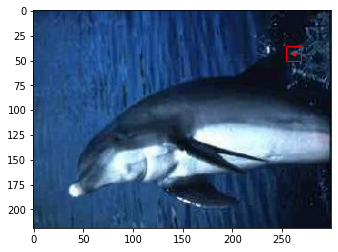

In [20]:
k = 10

centroid = centers[random.randint(0, k)]

closest_to_centroid = find_closest_descriptor(centroid, desc_all_train_imgs)
image_closest, kp_closest, desc_closest = find_image(closest_to_centroid, train_x)

plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
ax.imshow(image_closest)
ax.plot(kp_closest.pt[0], kp_closest.pt[1], '.', color='r')
rect = patches.Rectangle((kp_closest.pt[0]-7.5, kp_closest.pt[1]-7.5), 15,15, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
print("Patch around centroid outlined in red")
centroid = centroid.reshape(16,8)

In [12]:
def generate_histogram_with_image(descriptors, centers): # descriptors is for a single image
    hist_arr = []
    num_bins = len(centers)
    for row in descriptors:
        min_dist = 9999999999999999999
        min_center_idx = -1
        center_idx = -1
        for center in centers:
            center_idx = center_idx + 1
            dist = np.linalg.norm(row - center)
            if dist < min_dist:
                min_dist = dist
                min_center_idx = center_idx
        hist_arr.append(min_center_idx)
    hist = np.histogram(hist_arr, bins=num_bins)
    plt.figure(figsize=(5,5))
    plt.hist(hist_arr, bins=num_bins)
    plt.show()
    return hist, hist_arr

In [13]:
def generate_histogram(descriptors, centers): # descriptors is for a single image
    hist_arr = []
    num_bins = len(centers)
    for row in descriptors:
        min_dist = 9999999999999999999
        min_center_idx = -1
        center_idx = -1
        for center in centers:
            center_idx = center_idx + 1
            dist = np.linalg.norm(row - center)
            if dist < min_dist:
                min_dist = dist
                min_center_idx = center_idx
        hist_arr.append(min_center_idx)
    hist = np.histogram(hist_arr, bins=num_bins)
    return hist, hist_arr

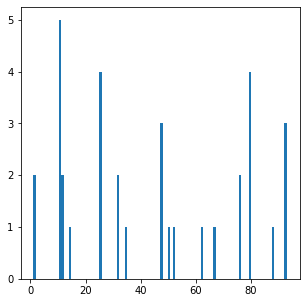

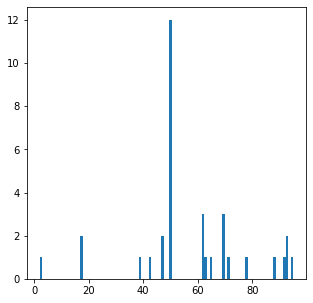

In [14]:
# purely for displaying the histograms

out = generate_histogram_with_image(train_x[5][3], centers)[0]
out = generate_histogram_with_image(train_x[16][3], centers)[0]

In [15]:
train_x_hists = []
train_x_hist_arrs = []
for (image, label, kp, descriptors) in train_x:
    hist, hist_arr = generate_histogram(descriptors, centers)[0]
    train_x_hists.append(hist)
    train_x_hist_arrs.append(hist_arr)

test_x_hists = []
test_x_hist_arrs = []
for (image, label, kp, descriptors) in test_x:
    hist, hist_arr = generate_histogram(descriptors, centers)[0]
    test_x_hists.append(hist)
    test_x_hist_arrs.append(hist_arr)

In [26]:
# use this later once we have our test and train cleaned up


model = OneVsRestClassifier(SVC()) # kernel='linear'
model.fit(train_x_hists, train_y)
prediction = model.predict(test_x_hists)
print(sk.metrics.classification_report(test_y, prediction))
confusion = sk.metrics.confusion_matrix(test_y, prediction)
print("     dolphin airplane leopard")
row_labels = ["dolphin", "airplane", "leopard"]
for row_label, row in zip(row_labels, confusion):
    print('%s [%s]' % (row_label, ' '.join('%03s' % i for i in row)))


# svclassifier = sk.svm.SVC(kernel='linear')
# svclassifier.fit(x_train, y_train)
# y_test_pred = svclassifier.predict(x_test)

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       1.00      0.43      0.60         7
           2       0.50      0.86      0.63         7

    accuracy                           0.62        21
   macro avg       0.72      0.62      0.62        21
weighted avg       0.72      0.62      0.62        21

     dolphin airplane leopard
dolphin [  4   0   3]
airplane [  1   3   3]
leopard [  1   0   6]


PREDICTED:  0
EXPECTED:  0


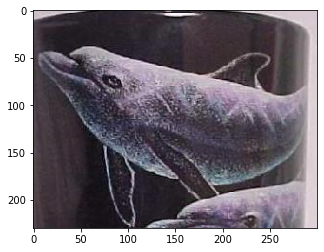

In [50]:
num = 1

hist, hist_arr = generate_histogram(test_x[num][3], centers)[0]

prediction = model.predict([hist])
print("PREDICTED: ", prediction[0])
print("EXPECTED: ", 0)


plt.imshow(test_x[num][0])

PREDICTED:  1
EXPECTED:  1


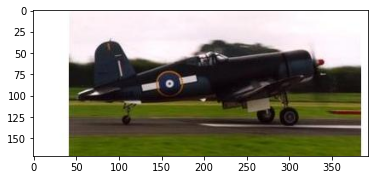

In [52]:
num = 8 

hist, hist_arr = generate_histogram(test_x[num][3], centers)[0]

prediction = model.predict([hist])
print("PREDICTED: ", prediction[0])
print("EXPECTED: ", 1)


plt.imshow(test_x[num][0])

PREDICTED:  2
EXPECTED:  2


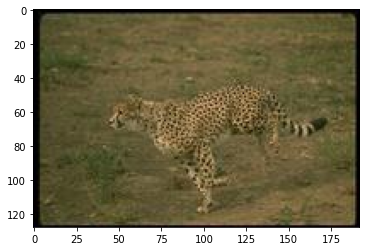

In [54]:
num = 18

hist, hist_arr = generate_histogram(test_x[num][3], centers)[0]

prediction = model.predict([hist])
print("PREDICTED: ", prediction[0])
print("EXPECTED: ", 2)

plt.imshow(test_x[num][0])